In [1]:
!hostname

gnode008.cluster


In [2]:
!nvidia-smi

Mon Jun 12 09:51:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:17:00.0 Off |                    0 |
| N/A   41C    P0   162W / 250W |   7030MiB / 40960MiB |     93%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
(1000, 400) (1000, 400)
(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 2.39 s, sys: 38.7 ms, total: 2.43 s
Wall time: 2.56 s


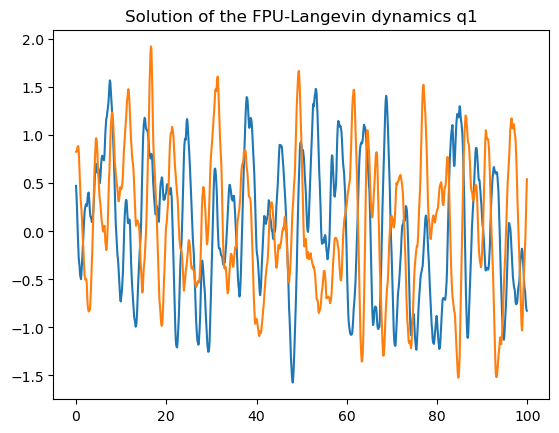

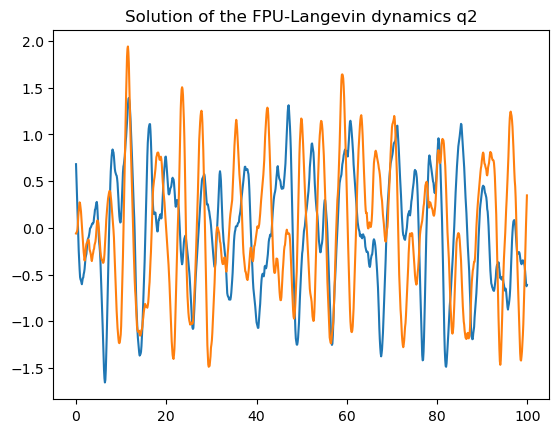

In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma1 = 1                             # coupling constant 
gamma2 = .5                            # coupling constant
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 
rho = 0.00                             # Correlation of q1 and q2 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q1_store = np.zeros([t_store.size+1,batch])
q2_store = np.zeros([t_store.size+1,batch])
# q_store = np.zeros([t_store.size+1,batch])
p1=np.zeros((2,batch))
p2=np.zeros((2,batch))
q1=np.zeros((2,batch))
q2=np.zeros((2,batch))

# solve SDE
j=1
for i in range(1,length):
     q1[1,:] = q1[0,:] + p1[0,:]*dt
     p1[1,:] = p1[0,:] + (-V_FPU(q1[0,:],U0,x0)-gamma1*p1[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma1/beta)
     q2[1,:] = q2[0,:] + p2[0,:]*dt
     p2[1,:] = p2[0,:] + (-V_FPU(q2[0,:],U0,x0)-gamma2*p2[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma2/beta)
     if i % gap ==0:            
            q1_store[j,:]=q1[1,:]
            q2_store[j,:]=rho*q1[1,:]+np.sqrt(1-rho**2)*q2[1,:]
            j=j+1
     p1[0,:]=p1[1,:]
     q1[0,:]=q1[1,:]
     p2[0,:]=p2[1,:]
     q2[0,:]=q2[1,:]

Toss=int(t_store.size/2)         
q1_store=q1_store[Toss:-1,:]         
q2_store=q2_store[Toss:-1,:]    
print(q1_store.shape,q2_store.shape)



plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q1")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q2")

# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q1=q1_store[0:sec_length,:]
Traj_q2=q2_store[0:sec_length,:]
print(ini.shape, Traj_q1.shape, Traj_q2.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q1
Traj[:,:,1] = Traj_q2
T=np.arange(len(Traj_q1[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

# 1. 1 input

In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


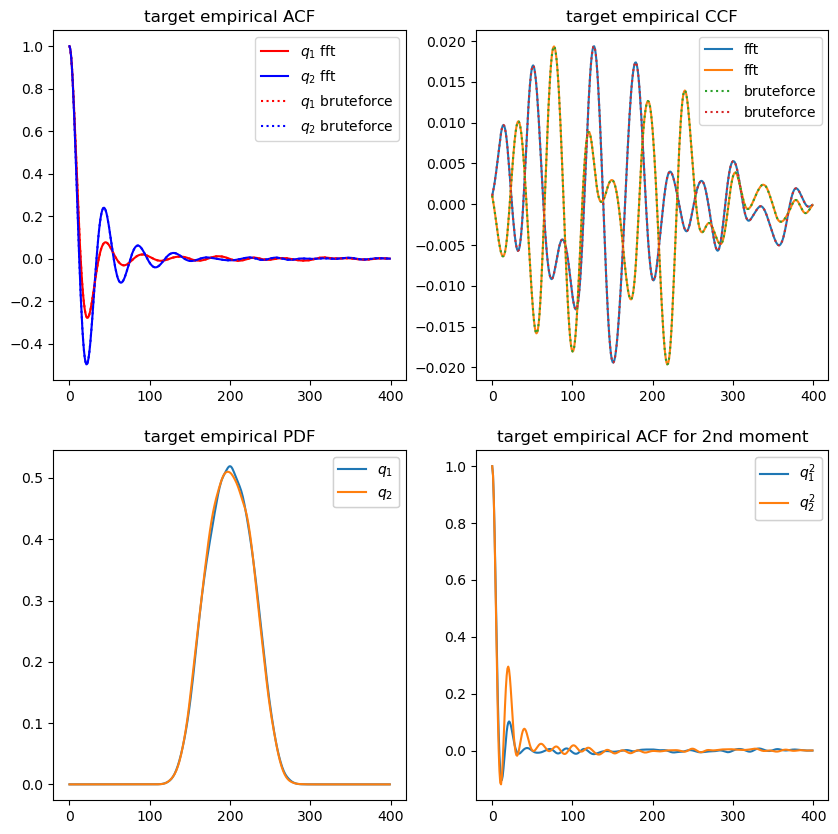

In [10]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_1$', r'$q_2$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_1^2$', r'$q_2^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

torch.Size([400, 2])


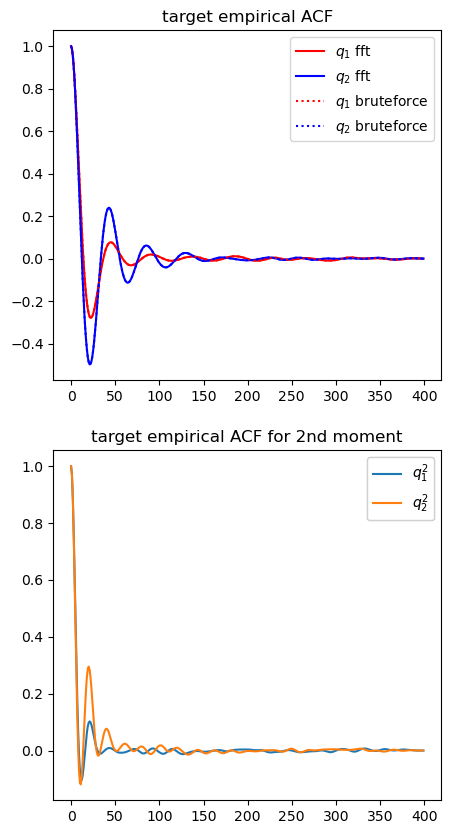

In [11]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
axs[0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0].legend()
axs[0].set_title('target empirical ACF')



print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1].legend(iter(sec_moment), (r'$q_1^2$', r'$q_2^2$'),loc=1)
axs[1].set_title('target empirical ACF for 2nd moment')
axs[1].add_artist(legend4)

plt.show()

## 1.3. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [12]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [13]:
### coefficients of loss functions
c1 = 1               # coefficient of CCF
c2 = 10              # coefficient of PDF
c3 = 1               # coefficient of ACF of second moment

In [14]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = c1*loss_ccf_bruteforce(pred_val)
            pdf = c2*loss_pdf_empirical(pred_val)
            acf_sec_moment = c3*loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if ccf <=0.0001 and pdf<=0.0001 and acf_sec_moment<=0.0001:
            break

if ccf > 0.0001 or pdf >0.0001 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')

[0]-th step loss: 2.5005, 2.4990, ccf: 0.00819, pdf: 2.48601, acf: 0.00477
[50]-th step loss: 2.3676, 2.3586, ccf: 0.00810, pdf: 2.34851, acf: 0.00199
[100]-th step loss: 0.7564, 0.7104, ccf: 0.00894, pdf: 0.69999, acf: 0.00143
[150]-th step loss: 0.1426, 0.1373, ccf: 0.01370, pdf: 0.12204, acf: 0.00156
[200]-th step loss: 0.0760, 0.0744, ccf: 0.01195, pdf: 0.06109, acf: 0.00141
[250]-th step loss: 0.0477, 0.0458, ccf: 0.01128, pdf: 0.03316, acf: 0.00137
[300]-th step loss: 0.0323, 0.0316, ccf: 0.01091, pdf: 0.01934, acf: 0.00136
[350]-th step loss: 0.0242, 0.0239, ccf: 0.01072, pdf: 0.01180, acf: 0.00136
[400]-th step loss: 0.0193, 0.0194, ccf: 0.01056, pdf: 0.00748, acf: 0.00136
[450]-th step loss: 0.0171, 0.0170, ccf: 0.01039, pdf: 0.00523, acf: 0.00136
[500]-th step loss: 0.0154, 0.0153, ccf: 0.01012, pdf: 0.00387, acf: 0.00134
[550]-th step loss: 0.0138, 0.0141, ccf: 0.00985, pdf: 0.00293, acf: 0.00132
[600]-th step loss: 0.0133, 0.0133, ccf: 0.00961, pdf: 0.00241, acf: 0.00131
[6

[5300]-th step loss: 0.0090, 0.0090, ccf: 0.00781, pdf: 0.00011, acf: 0.00108
[5350]-th step loss: 0.0090, 0.0090, ccf: 0.00780, pdf: 0.00008, acf: 0.00109
[5400]-th step loss: 0.0090, 0.0090, ccf: 0.00779, pdf: 0.00012, acf: 0.00108
[5450]-th step loss: 0.0091, 0.0090, ccf: 0.00777, pdf: 0.00011, acf: 0.00109
[5500]-th step loss: 0.0089, 0.0090, ccf: 0.00776, pdf: 0.00014, acf: 0.00110
[5550]-th step loss: 0.0091, 0.0089, ccf: 0.00775, pdf: 0.00009, acf: 0.00109
[5600]-th step loss: 0.0090, 0.0091, ccf: 0.00773, pdf: 0.00022, acf: 0.00110
[5650]-th step loss: 0.0088, 0.0090, ccf: 0.00771, pdf: 0.00019, acf: 0.00111
[5700]-th step loss: 0.0088, 0.0089, ccf: 0.00771, pdf: 0.00012, acf: 0.00111
[5750]-th step loss: 0.0090, 0.0089, ccf: 0.00770, pdf: 0.00009, acf: 0.00110
[5800]-th step loss: 0.0088, 0.0090, ccf: 0.00769, pdf: 0.00016, acf: 0.00110
[5850]-th step loss: 0.0089, 0.0089, ccf: 0.00767, pdf: 0.00009, acf: 0.00111
[5900]-th step loss: 0.0088, 0.0089, ccf: 0.00765, pdf: 0.00009,

[10550]-th step loss: 0.0011, 0.0009, ccf: 0.00050, pdf: 0.00021, acf: 0.00023
[10600]-th step loss: 0.0009, 0.0011, ccf: 0.00048, pdf: 0.00040, acf: 0.00022
[10650]-th step loss: 0.0009, 0.0010, ccf: 0.00047, pdf: 0.00034, acf: 0.00023
[10700]-th step loss: 0.0008, 0.0009, ccf: 0.00046, pdf: 0.00024, acf: 0.00021
[10750]-th step loss: 0.0009, 0.0010, ccf: 0.00044, pdf: 0.00030, acf: 0.00022
[10800]-th step loss: 0.0011, 0.0010, ccf: 0.00043, pdf: 0.00040, acf: 0.00020
[10850]-th step loss: 0.0008, 0.0009, ccf: 0.00043, pdf: 0.00030, acf: 0.00021
[10900]-th step loss: 0.0009, 0.0008, ccf: 0.00040, pdf: 0.00019, acf: 0.00020
[10950]-th step loss: 0.0009, 0.0008, ccf: 0.00038, pdf: 0.00023, acf: 0.00020
[11000]-th step loss: 0.0008, 0.0008, ccf: 0.00038, pdf: 0.00019, acf: 0.00019
[11050]-th step loss: 0.0007, 0.0008, ccf: 0.00037, pdf: 0.00024, acf: 0.00019
[11100]-th step loss: 0.0007, 0.0008, ccf: 0.00037, pdf: 0.00026, acf: 0.00018
[11150]-th step loss: 0.0009, 0.0009, ccf: 0.00036, 

[15750]-th step loss: 0.0006, 0.0006, ccf: 0.00027, pdf: 0.00023, acf: 0.00011
[15800]-th step loss: 0.0005, 0.0005, ccf: 0.00025, pdf: 0.00010, acf: 0.00011
[15850]-th step loss: 0.0008, 0.0004, ccf: 0.00025, pdf: 0.00007, acf: 0.00011
[15900]-th step loss: 0.0005, 0.0005, ccf: 0.00026, pdf: 0.00016, acf: 0.00011
[15950]-th step loss: 0.0005, 0.0004, ccf: 0.00025, pdf: 0.00007, acf: 0.00011
[16000]-th step loss: 0.0006, 0.0007, ccf: 0.00028, pdf: 0.00025, acf: 0.00012
[16050]-th step loss: 0.0005, 0.0005, ccf: 0.00026, pdf: 0.00012, acf: 0.00012
[16100]-th step loss: 0.0006, 0.0006, ccf: 0.00024, pdf: 0.00021, acf: 0.00012
[16150]-th step loss: 0.0005, 0.0004, ccf: 0.00025, pdf: 0.00007, acf: 0.00011
[16200]-th step loss: 0.0005, 0.0006, ccf: 0.00025, pdf: 0.00020, acf: 0.00011
[16250]-th step loss: 0.0004, 0.0005, ccf: 0.00025, pdf: 0.00012, acf: 0.00011
[16300]-th step loss: 0.0006, 0.0005, ccf: 0.00026, pdf: 0.00011, acf: 0.00011
[16350]-th step loss: 0.0006, 0.0005, ccf: 0.00025, 

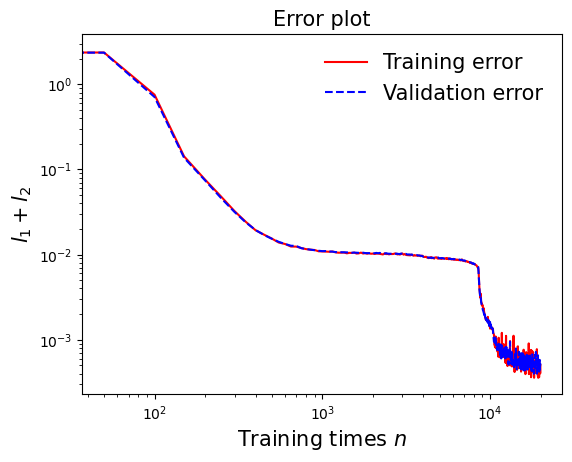

In [15]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

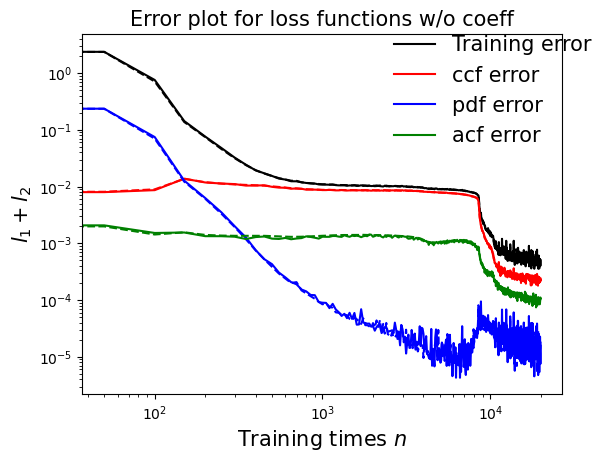

In [16]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

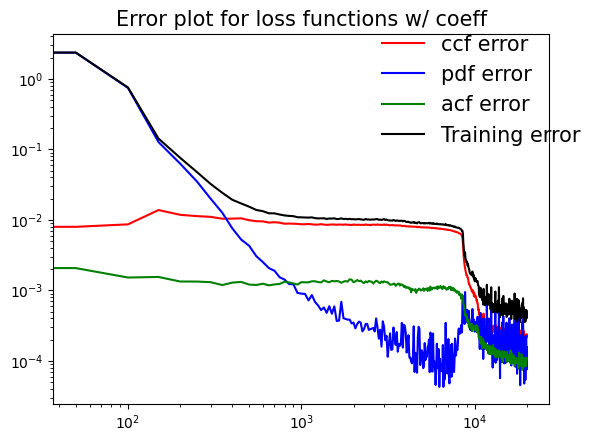

In [17]:
T_ccf_new = [i * c1 for i in T_ccf]
T_pdf_new = [i * c2 for i in T_pdf]
T_acf_new = [i * c3 for i in T_acf]
T_err_new = [x + y + z for x, y, z in zip(T_ccf_new, T_pdf_new, T_acf_new)]
plt.title("Error plot for loss functions w/ coeff",fontsize=15) 
plt.loglog(Step, T_ccf_new,'r',label='ccf error')
plt.loglog(Step, T_pdf_new,'b',label='pdf error')
plt.loglog(Step, T_acf_new,'g',label='acf error')

plt.loglog(Step, T_error,'k',label='Training error')
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [18]:
def test1(Traj, T, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

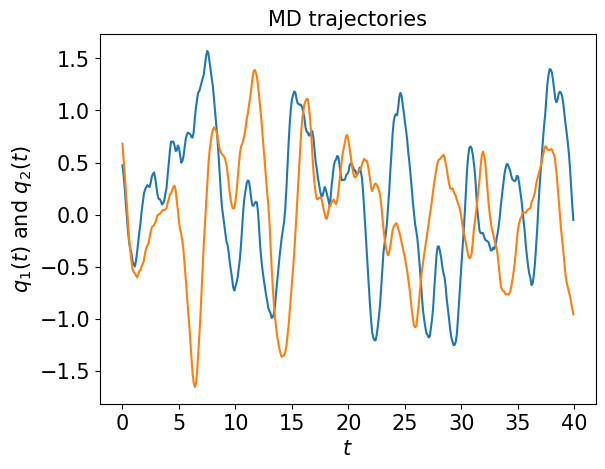

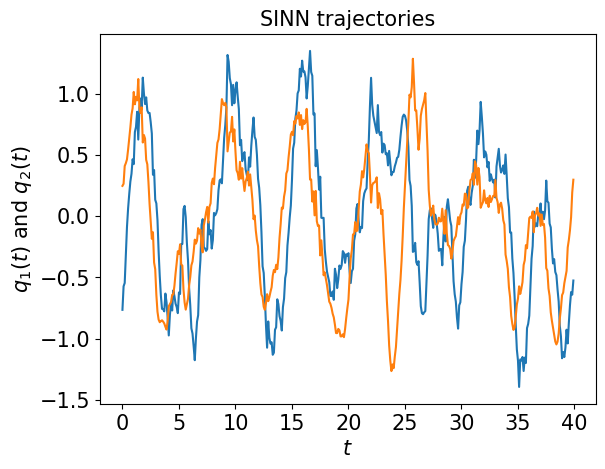

In [19]:
test1(Traj, T, net)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [20]:
def test2(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p=ccf_p.detach().cpu().numpy()
    corr_t=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_1$',fontsize=15)    
    plt.plot(T, corr_t[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_2$',fontsize=15)          
    plt.plot(T, corr_t[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t[...,1:3],'r')        # correlation function of the target 
    plt.plot(T, corr_p[...,1:3], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])

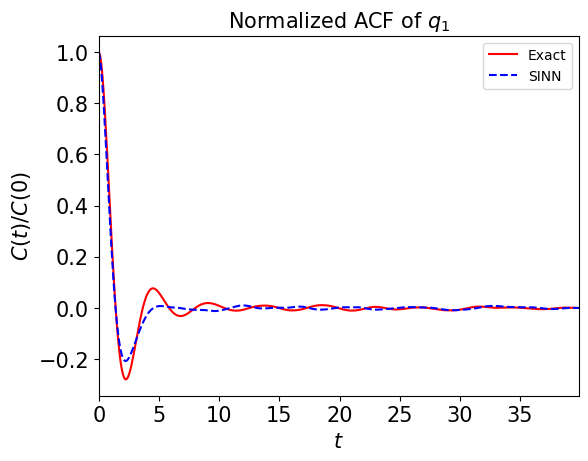

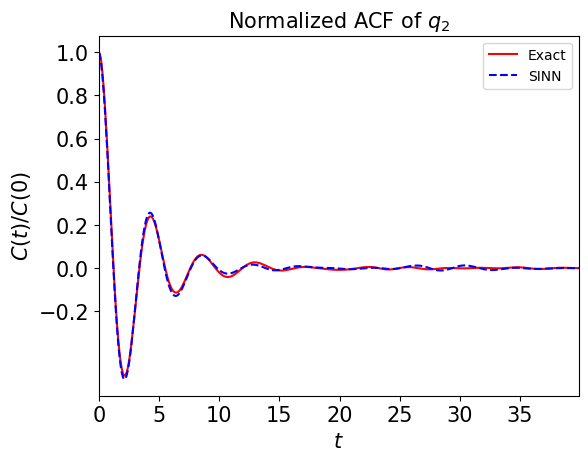

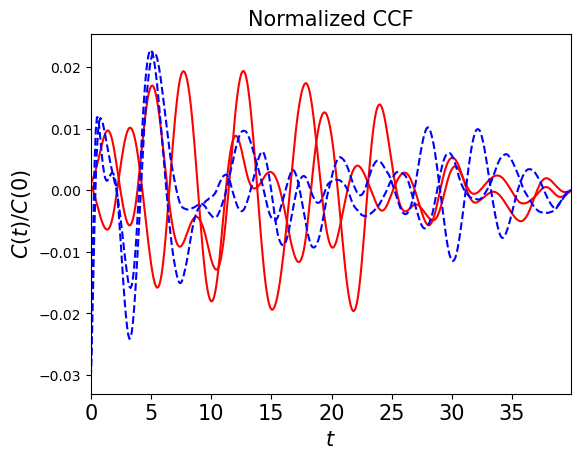

In [21]:
test2(target, net)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [22]:
def test3(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 100,None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100,None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100,None).cpu()


    x=np.linspace(-5, 5, 100)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

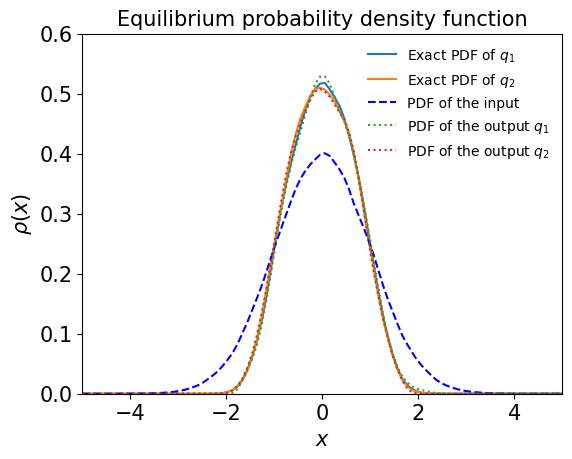

In [23]:
test3(target, net)

## Test 4: Comparing the higher-order ACF

In [24]:
def test4(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_1^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_2^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    
    
    
    
    
    


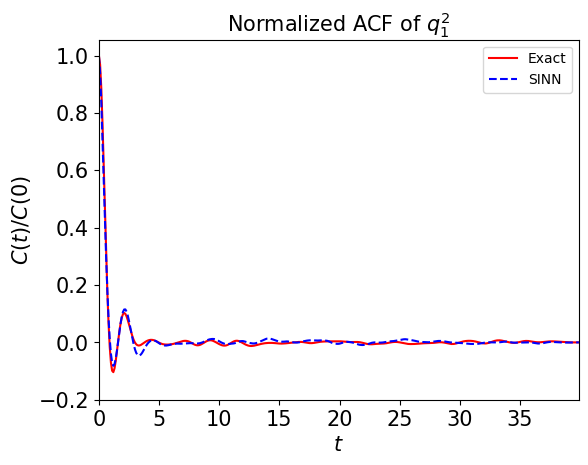

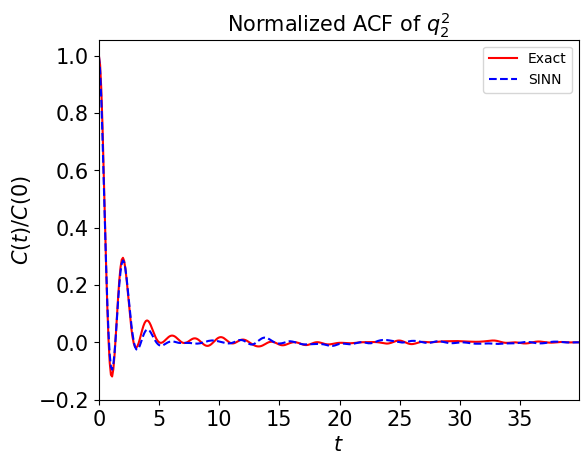

In [25]:
test4(target, net)

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [26]:
def test5(q1_store, q2_store, net):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= net(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

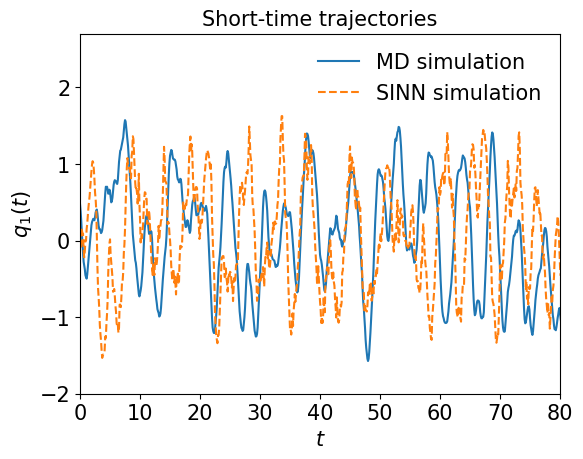

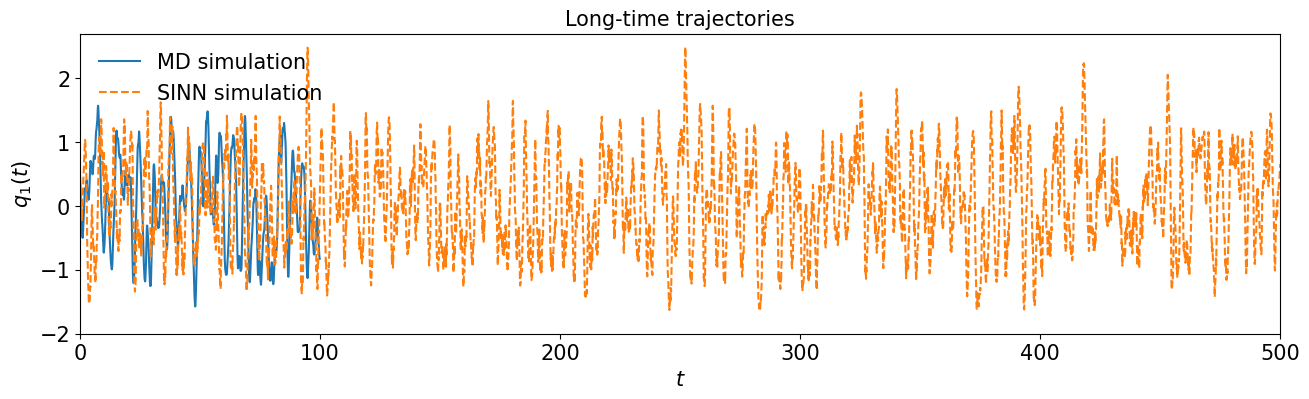

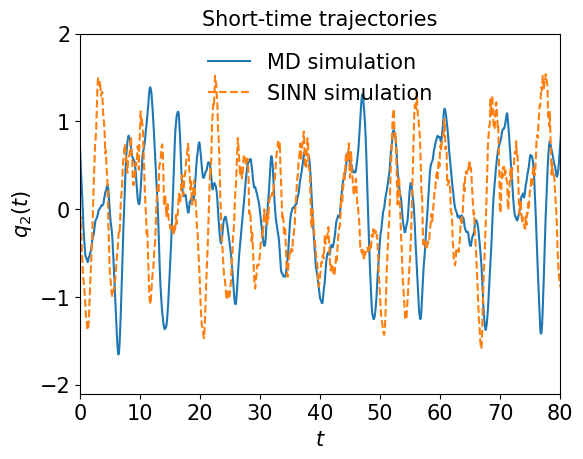

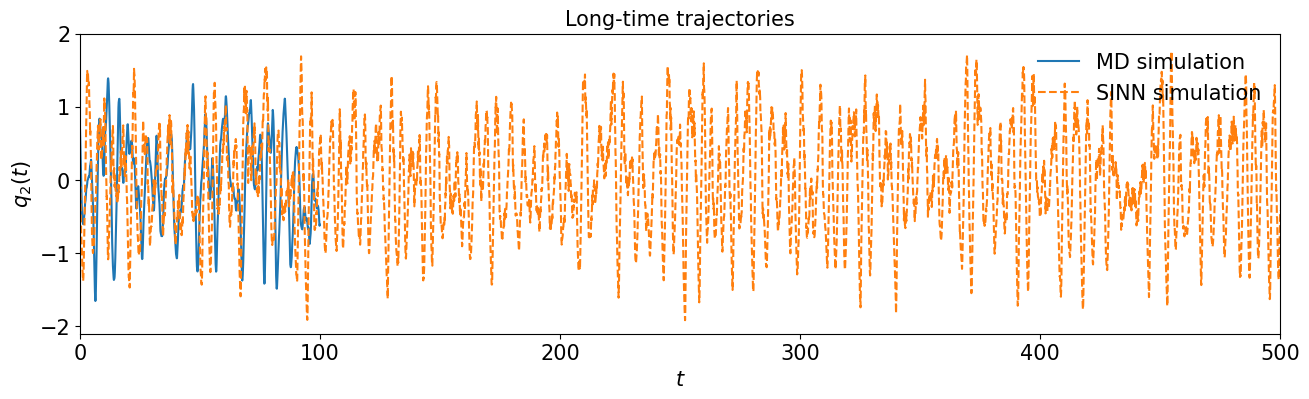

In [27]:
test5(q1_store, q2_store, net)

# 2. 2 inputs

In [28]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [29]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

In [48]:
### Defining SINN model
net = SINN(2, 10, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [49]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = c1*loss_ccf_bruteforce(pred_val)
            pdf = c2*loss_pdf_empirical(pred_val)
            acf_sec_moment = c3*loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if ccf <=0.0001 and pdf<=0.0001 and acf_sec_moment<=0.0001:
            break

if ccf > 0.0001 or pdf >0.0001 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')

[0]-th step loss: 2.4771, 2.4754, ccf: 0.00560, pdf: 2.46766, acf: 0.00211
[50]-th step loss: 1.5830, 1.5135, ccf: 0.00476, pdf: 1.50743, acf: 0.00134
[100]-th step loss: 0.1397, 0.1363, ccf: 0.00996, pdf: 0.12421, acf: 0.00208
[150]-th step loss: 0.0356, 0.0345, ccf: 0.00648, pdf: 0.02632, acf: 0.00172
[200]-th step loss: 0.0214, 0.0214, ccf: 0.00586, pdf: 0.01419, acf: 0.00139
[250]-th step loss: 0.0158, 0.0162, ccf: 0.00529, pdf: 0.00965, acf: 0.00124
[300]-th step loss: 0.0126, 0.0130, ccf: 0.00494, pdf: 0.00692, acf: 0.00116
[350]-th step loss: 0.0109, 0.0110, ccf: 0.00474, pdf: 0.00511, acf: 0.00113
[400]-th step loss: 0.0095, 0.0095, ccf: 0.00458, pdf: 0.00379, acf: 0.00112
[450]-th step loss: 0.0084, 0.0085, ccf: 0.00448, pdf: 0.00288, acf: 0.00112
[500]-th step loss: 0.0076, 0.0076, ccf: 0.00438, pdf: 0.00213, acf: 0.00112
[550]-th step loss: 0.0069, 0.0071, ccf: 0.00428, pdf: 0.00165, acf: 0.00113
[600]-th step loss: 0.0067, 0.0066, ccf: 0.00419, pdf: 0.00126, acf: 0.00113
[6

[5300]-th step loss: 0.0005, 0.0004, ccf: 0.00019, pdf: 0.00010, acf: 0.00010
[5350]-th step loss: 0.0003, 0.0006, ccf: 0.00019, pdf: 0.00026, acf: 0.00010
[5400]-th step loss: 0.0004, 0.0005, ccf: 0.00020, pdf: 0.00017, acf: 0.00010
[5450]-th step loss: 0.0004, 0.0005, ccf: 0.00020, pdf: 0.00017, acf: 0.00011
[5500]-th step loss: 0.0004, 0.0004, ccf: 0.00019, pdf: 0.00009, acf: 0.00010
[5550]-th step loss: 0.0004, 0.0005, ccf: 0.00019, pdf: 0.00017, acf: 0.00010
[5600]-th step loss: 0.0004, 0.0004, ccf: 0.00019, pdf: 0.00013, acf: 0.00010
[5650]-th step loss: 0.0004, 0.0004, ccf: 0.00018, pdf: 0.00009, acf: 0.00011
[5700]-th step loss: 0.0003, 0.0003, ccf: 0.00018, pdf: 0.00006, acf: 0.00010
[5750]-th step loss: 0.0004, 0.0004, ccf: 0.00019, pdf: 0.00011, acf: 0.00009
[5800]-th step loss: 0.0007, 0.0004, ccf: 0.00025, pdf: 0.00011, acf: 0.00009
[5850]-th step loss: 0.0003, 0.0003, ccf: 0.00017, pdf: 0.00007, acf: 0.00010
[5900]-th step loss: 0.0005, 0.0004, ccf: 0.00019, pdf: 0.00014,

[10550]-th step loss: 0.0003, 0.0003, ccf: 0.00013, pdf: 0.00007, acf: 0.00006
[10600]-th step loss: 0.0007, 0.0004, ccf: 0.00011, pdf: 0.00020, acf: 0.00006
[10650]-th step loss: 0.0014, 0.0011, ccf: 0.00030, pdf: 0.00072, acf: 0.00012
[10700]-th step loss: 0.0006, 0.0006, ccf: 0.00016, pdf: 0.00039, acf: 0.00008
[10750]-th step loss: 0.0004, 0.0003, ccf: 0.00015, pdf: 0.00006, acf: 0.00007
[10800]-th step loss: 0.0003, 0.0003, ccf: 0.00012, pdf: 0.00009, acf: 0.00006
[10850]-th step loss: 0.0003, 0.0003, ccf: 0.00013, pdf: 0.00007, acf: 0.00006
[10900]-th step loss: 0.0006, 0.0004, ccf: 0.00013, pdf: 0.00021, acf: 0.00006
[10950]-th step loss: 0.0004, 0.0002, ccf: 0.00012, pdf: 0.00006, acf: 0.00006
[11000]-th step loss: 0.0002, 0.0003, ccf: 0.00012, pdf: 0.00009, acf: 0.00007
[11050]-th step loss: 0.0004, 0.0003, ccf: 0.00012, pdf: 0.00011, acf: 0.00007
[11100]-th step loss: 0.0003, 0.0002, ccf: 0.00013, pdf: 0.00004, acf: 0.00006
[11150]-th step loss: 0.0004, 0.0003, ccf: 0.00012, 

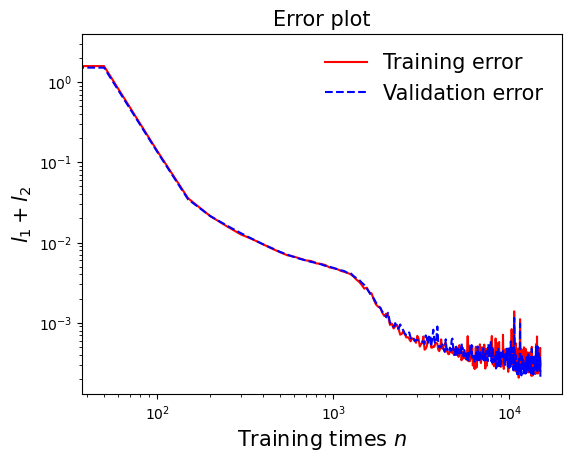

In [50]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

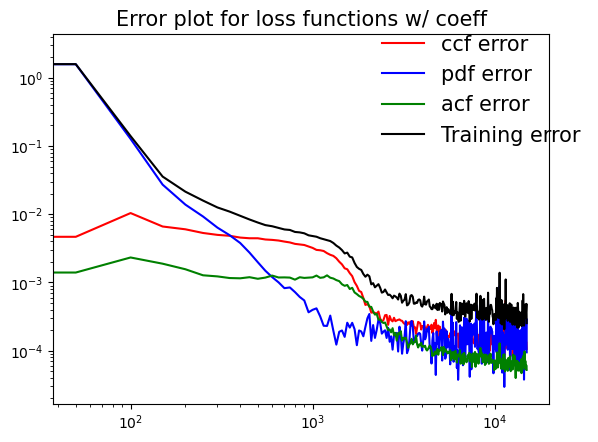

In [51]:
T_ccf_new = [i * c1 for i in T_ccf]
T_pdf_new = [i * c2 for i in T_pdf]
T_acf_new = [i * c3 for i in T_acf]
T_err_new = [x + y + z for x, y, z in zip(T_ccf_new, T_pdf_new, T_acf_new)]
plt.title("Error plot for loss functions w/ coeff",fontsize=15) 
plt.loglog(Step, T_ccf_new,'r',label='ccf error')
plt.loglog(Step, T_pdf_new,'b',label='pdf error')
plt.loglog(Step, T_acf_new,'g',label='acf error')

plt.loglog(Step, T_error,'k',label='Training error')
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

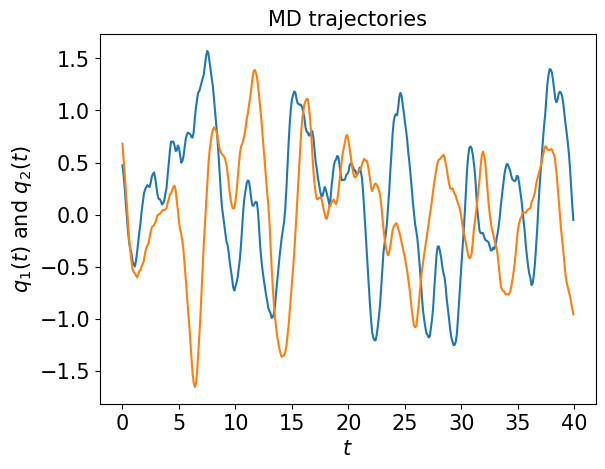

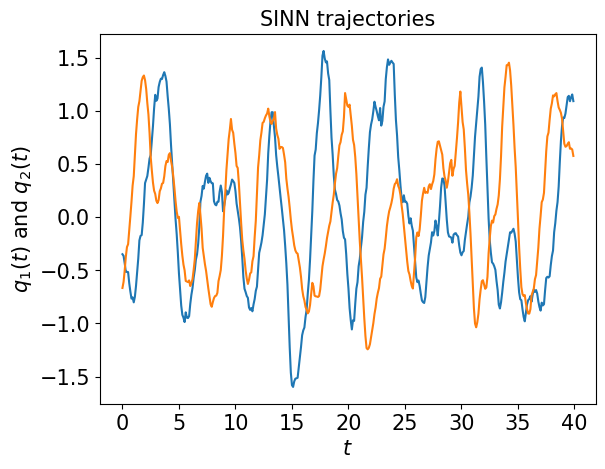

In [52]:
test1(Traj, T, net)

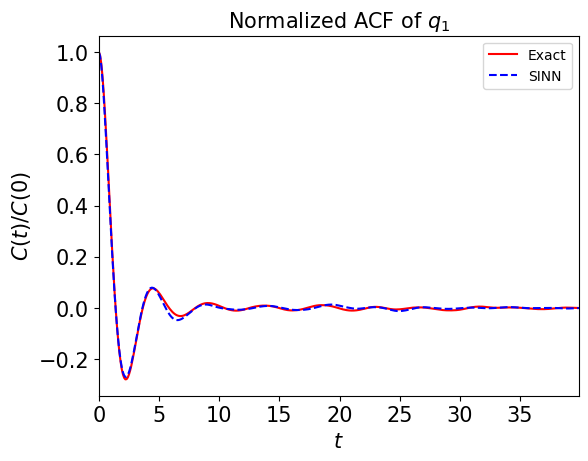

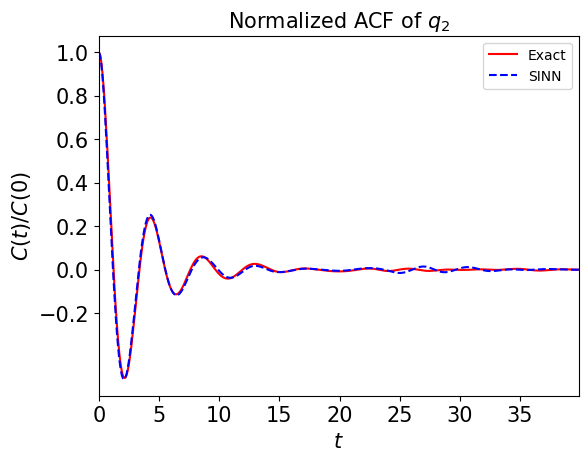

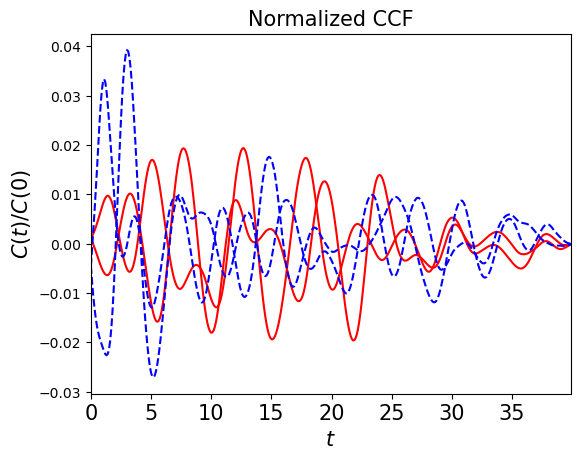

In [53]:
test2(target, net)

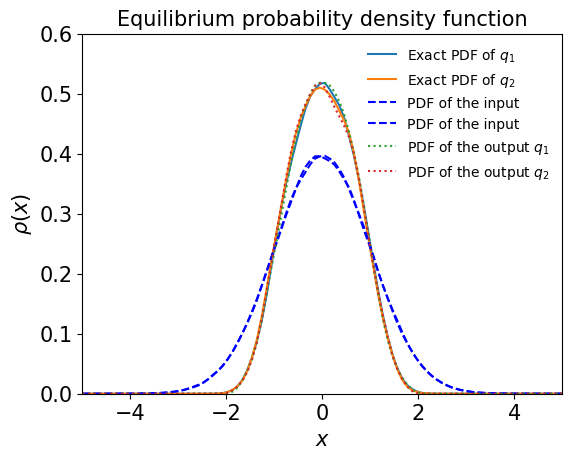

In [54]:
test3(target, net)

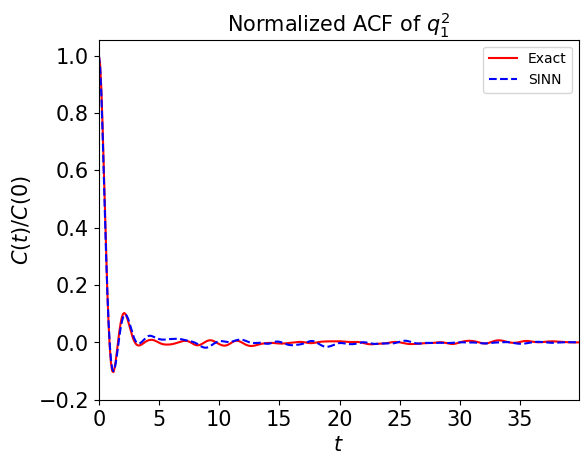

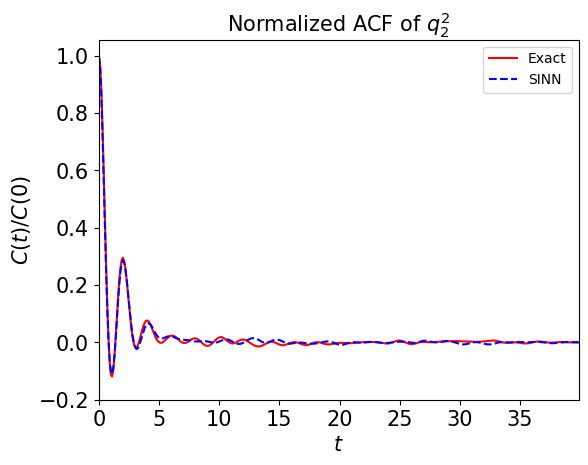

In [55]:
test4(target, net)

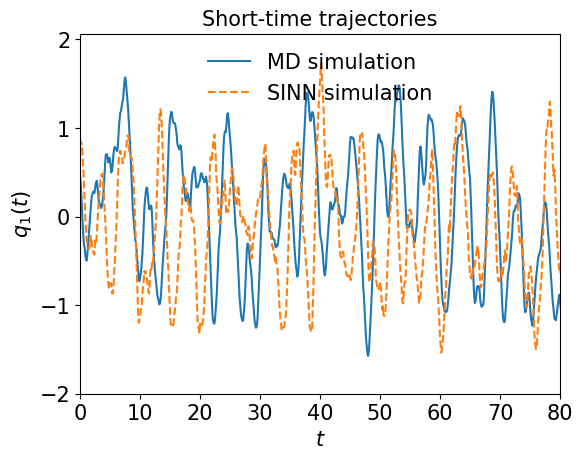

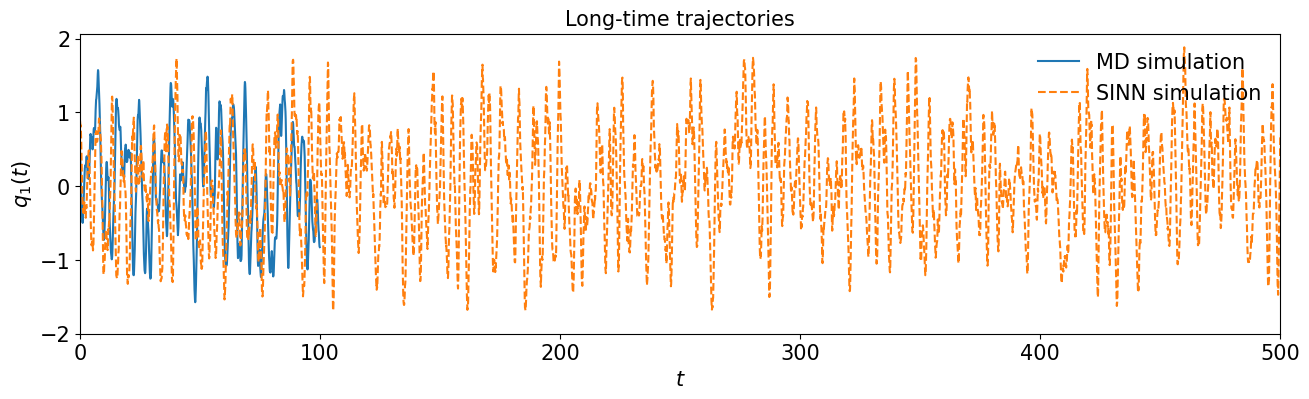

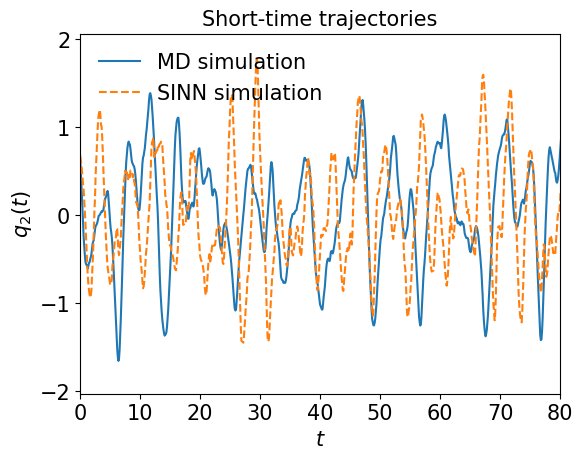

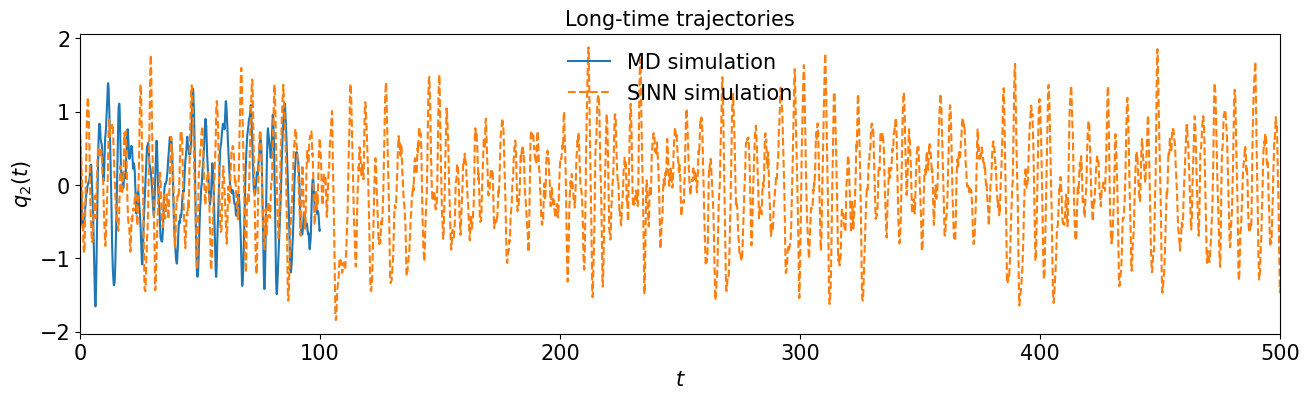

In [56]:
test5(q1_store, q2_store, net)